In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import sys
sys.path.append("external/glasbey")
from glasbey import Glasbey


In [3]:
def get_colors(scheme: str, names=None, n_colors:int = -1, use_white:bool=False,
               white_name:str = "N/A", n_seq = 10) -> [dict, np.array]:
    """
    :param scheme: {'sequential', 'divergent', 'categorical'}
    :param n_colors: int
        Number of colors needed
    :param use_white: bool
        If True, white will also be geneated, which will be the first index.
    :return:
    """
    if scheme == "categorical":
        if names is None:
            print("Need a list of names to create dictionary")
            raise TypeError
        gb = Glasbey()
        p = gb.generate_palette(size=n_colors + 1)
        # Needed for Float problems
        p[p > 1] = 1
        p[p < 0] = 0
        color_map = {name: p[ind + 1] for ind, name in
                     enumerate(set(names))}
        if use_white:
            color_map[white_name] = p[0]
    elif scheme == 'divergent':
        bmap = brewer2mpl.get_map('Divergent', 'Blues', n_seq)
        color_map = bmap.mpl_colormap
    elif scheme == "categorical":
        bmap = brewer2mpl.get_map('sequential', 'Qualitative', 5)

    name_map = {val: ind for ind, val in enumerate(names)}

    return color_map, name_map, p


def create_color_df(meta_df, use_white:bool=False,
               white_name:str = "N/A"):
    """Assumes each column is categorical for now. Creates a df with the same dimensions but now in its colors, along with the legend map."""
    meta_df_color = meta_df.copy()
    n_colors = 0
    labels = []
    for col in meta_df_color.columns.values:
        n_colors += len(meta_df[col].unique())
        labels += list(set(meta_df[col].values))
    color_map, name_map, p = get_colors("categorical", names=labels, n_colors=n_colors, use_white=use_white, white_name=white_name)       
    for col in meta_df_color.columns.values:
        meta_df_color[col] = meta_df[col].map(color_map)
        
    return meta_df_color, color_map, name_map, p, labels

def legend_from_color(color_map, curr_ax, f=None,bbox_to_anchor=(1.15, 0.75)):
    markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o',
                          linestyle='') for color in color_map.values()]
#     curr_ax.legend(markers, list(color_map.keys()),
#                    numpoints=1, loc='upper right')
    curr_ax.legend(markers, list(color_map.keys()),
                   bbox_to_anchor=(1.15, 0.75))
    return


## Randomized data

In [4]:
df = pd.DataFrame(np.random.randint(0,10,[10,20]))
df.columns  =  [chr(i) for i in range(65,85)]

groups_d = ["No Drug", "Drug A", "Drug B"]
groups_A = ["WT", "A"]
groups_B = ["WT", "B"]

meta = dict()
meta["Drug"] = np.random.choice(groups_d,replace=True,size=len(df.columns))
meta["Gene A"] = np.random.choice(groups_A,replace=True,size=len(df.columns))
meta["Gene B"] = np.random.choice(groups_B,replace=True,size=len(df.columns))
meta_df = pd.DataFrame(meta)
meta_df.index = df.columns

genes_A = ["secM","secP", "Other"]
genes_B = np.arange(10)
genes_df = dict()
genes_df["Pathway"] = np.random.choice(genes_A,replace=True,size=len(df.index))
genes_df["Score"] = np.random.choice(genes_B,replace=True,size=len(df.index))
genes_df = pd.DataFrame(genes_df)
meta_df


,Drug,Gene A,Gene B
A,Drug B,A,B
B,Drug A,WT,WT
C,Drug A,A,B
D,No Drug,WT,B
E,No Drug,WT,B
F,Drug A,WT,B
G,Drug A,A,B
H,Drug B,A,B
I,No Drug,A,B
J,No Drug,A,WT


In [5]:
genes_df

,Pathway,Score
0,secM,1
1,secM,1
2,secP,7
3,secP,2
4,secM,6
5,secP,9
6,Other,1
7,secP,4
8,Other,9
9,secM,9


In [15]:
def plot_cluster(df: pd.DataFrame,
                 row_meta=None,
                 col_meta=None,
                 fsave=None,
                 to_z=False,
                 to_col_clust=True,
                 to_row_clust=True,
                 name=None,
                 col_names=True,
                 row_names=True,
                 to_legend=True,
                 method="average", **clust_kws):
    """Clusters dataframe, and includes different layers of metadata about the row and column da

    df: Dataframe to cluster on
    {row, col}_meta: meta DF with different groups. Indices are the df index IDs and the columns are different potential ways to group them
    name: Label of the graph
    fsave: Name to save the figure. Default is None, which will not save
    {row,col}_names: To keep the labels or not for the columns
    """

    z = None
    if to_z:
        z = 0
        
    if col_meta is not None:
        col_meta_color, col_color_map, name_map, p, labels = create_color_df(col_meta, use_white=True, white_name="WT")
    else:
        col_meta_color=None
    
    if row_meta is not None:
        row_meta_color, row_color_map, name_map, p, labels = create_color_df(row_meta, use_white=True, white_name="WT")
    else:
        row_meta_color=None


    g = sns.clustermap(
        df,
        z_score=z,
        col_cluster=to_col_clust,
        row_cluster=to_row_clust,
        col_colors=col_meta_color,
        row_colors=row_meta_color,
        method=method,
        cmap="RdBu_r", **clust_kws)

    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(),rotation=90, fontsize=8)

    if not col_names:
        g.ax_heatmap.set_xticks([])
        g.ax_heatmap.set_xticklabels("")
    if not row_names:
        g.ax_heatmap.set_yticks([])
        g.ax_heatmap.set_yticklabels("")


    if to_legend is not None and col_meta_color is not None :
        print(col_color_map)
        legend_from_color(col_color_map, curr_ax=g.ax_col_dendrogram)
    if to_legend is not None and row_meta_color is not None :
        print(row_color_map)
        legend_from_color(row_color_map, curr_ax=g.ax_heatmap) #g.ax_row_dendrogram)
        
    if name is not None:
        g.fig.suptitle(name)
    if fsave is not None:
        fsave = fsave.replace(".png","")
        g.savefig(fsave + ".png", bbox_inches='tight', transparent=True, markerfacecolor="None")
        g.savefig(fsave + ".svg", bbox_inches='tight', transparent=True, markerfacecolor="None")
        g.savefig(fsave + ".pdf", bbox_inches='tight', transparent=True, markerfacecolor="None")
        
    return g




{'Drug A': array([5.88229881e-42, 5.64082875e-42, 5.59612427e-42]), 'A': array([0.84313725, 0.        , 0.        ]), 'Drug B': array([0.54901961, 0.23529412, 1.        ]), 'B': array([7.84313725e-03, 5.33333333e-01, 1.31113870e-15]), 'No Drug': array([0.        , 0.6745098 , 0.78039216]), 'WT': array([1., 1., 1.])}
{1: array([5.88229881e-42, 5.64082875e-42, 5.59612427e-42]), 2: array([0.84313725, 0.        , 0.        ]), 4: array([0.54901961, 0.23529412, 1.        ]), 6: array([7.84313725e-03, 5.33333333e-01, 1.31113870e-15]), 7: array([0.        , 0.6745098 , 0.78039216]), 9: array([5.96078431e-01, 1.00000000e+00, 8.06854583e-16]), 'secM': array([1.        , 0.49803922, 0.81960784]), 'Other': array([4.23529412e-01, 8.96505092e-16, 3.09803922e-01]), 'secP': array([1.        , 0.64705882, 0.18823529]), 'WT': array([1., 1., 1.])}


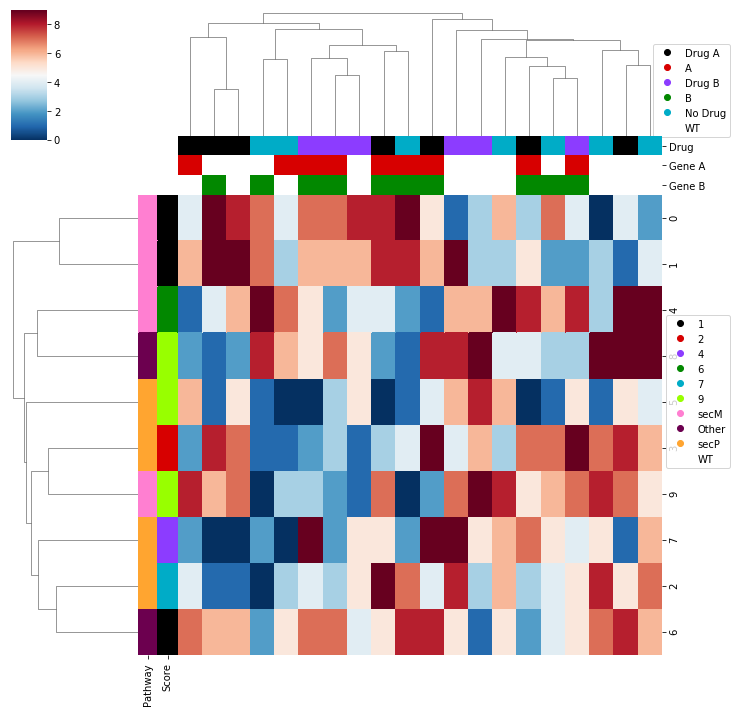

In [17]:
plot_cluster(df,
             row_meta=genes_df,
             col_meta=meta_df,
             fsave=None,
             to_z=False,
             to_col_clust=True,
             to_row_clust=True,
             name=None,
             col_names=False,
             row_names = True,
             to_legend=True,
             method="average")#, {"figsize": (10,10)})

In [25]:
df

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T
0,7,4,8,7,7,9,5,7,9,4,6,8,3,4,8,0,2,4,3,1
1,6,1,8,2,7,9,6,6,8,3,3,9,5,2,6,3,4,6,3,9
2,3,5,9,4,0,1,4,4,7,3,6,1,3,5,5,8,7,4,3,8
3,3,8,3,7,1,8,9,2,4,1,3,7,7,9,1,7,6,2,6,4
4,2,9,4,6,9,4,1,5,2,7,9,6,8,8,4,3,9,1,6,6
5,3,5,0,1,1,1,4,0,1,0,6,5,0,5,5,1,4,6,8,6
6,7,8,5,4,2,6,8,7,8,5,5,6,2,5,4,7,6,7,1,5
7,2,1,5,5,2,0,9,9,2,0,6,0,7,4,5,5,6,2,5,9
8,7,9,2,3,8,1,8,5,1,6,4,2,4,3,5,9,9,2,9,8
9,2,7,7,6,0,6,2,3,0,3,8,7,5,7,1,8,5,8,9,7


## Shows that the kwargs works 

{'Drug A': array([5.88229881e-42, 5.64082875e-42, 5.59612427e-42]), 'A': array([0.84313725, 0.        , 0.        ]), 'Drug B': array([0.54901961, 0.23529412, 1.        ]), 'B': array([7.84313725e-03, 5.33333333e-01, 1.31113870e-15]), 'No Drug': array([0.        , 0.6745098 , 0.78039216]), 'WT': array([1., 1., 1.])}
{1: array([5.88229881e-42, 5.64082875e-42, 5.59612427e-42]), 2: array([0.84313725, 0.        , 0.        ]), 4: array([0.54901961, 0.23529412, 1.        ]), 6: array([7.84313725e-03, 5.33333333e-01, 1.31113870e-15]), 7: array([0.        , 0.6745098 , 0.78039216]), 9: array([5.96078431e-01, 1.00000000e+00, 8.06854583e-16]), 'secM': array([1.        , 0.49803922, 0.81960784]), 'Other': array([4.23529412e-01, 8.96505092e-16, 3.09803922e-01]), 'secP': array([1.        , 0.64705882, 0.18823529]), 'WT': array([1., 1., 1.])}


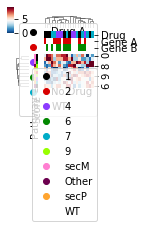

In [24]:
plot_cluster(df,
             row_meta=genes_df,
             col_meta=meta_df,
             fsave=None,
             to_z=False,
             to_col_clust=True,
             to_row_clust=True,
             name=None,
             col_names=False,
             row_names = True,
             to_legend=True,
             method="average" , **{"figsize": (2,2), "colors_ratio":(0.03, 0.1)})

## Show the kwargs in the sns clustermap kwargs works

{'Drug A': array([5.88229881e-42, 5.64082875e-42, 5.59612427e-42]), 'A': array([0.84313725, 0.        , 0.        ]), 'Drug B': array([0.54901961, 0.23529412, 1.        ]), 'B': array([7.84313725e-03, 5.33333333e-01, 1.31113870e-15]), 'No Drug': array([0.        , 0.6745098 , 0.78039216]), 'WT': array([1., 1., 1.])}
{1: array([5.88229881e-42, 5.64082875e-42, 5.59612427e-42]), 2: array([0.84313725, 0.        , 0.        ]), 4: array([0.54901961, 0.23529412, 1.        ]), 6: array([7.84313725e-03, 5.33333333e-01, 1.31113870e-15]), 7: array([0.        , 0.6745098 , 0.78039216]), 9: array([5.96078431e-01, 1.00000000e+00, 8.06854583e-16]), 'secM': array([1.        , 0.49803922, 0.81960784]), 'Other': array([4.23529412e-01, 8.96505092e-16, 3.09803922e-01]), 'secP': array([1.        , 0.64705882, 0.18823529]), 'WT': array([1., 1., 1.])}


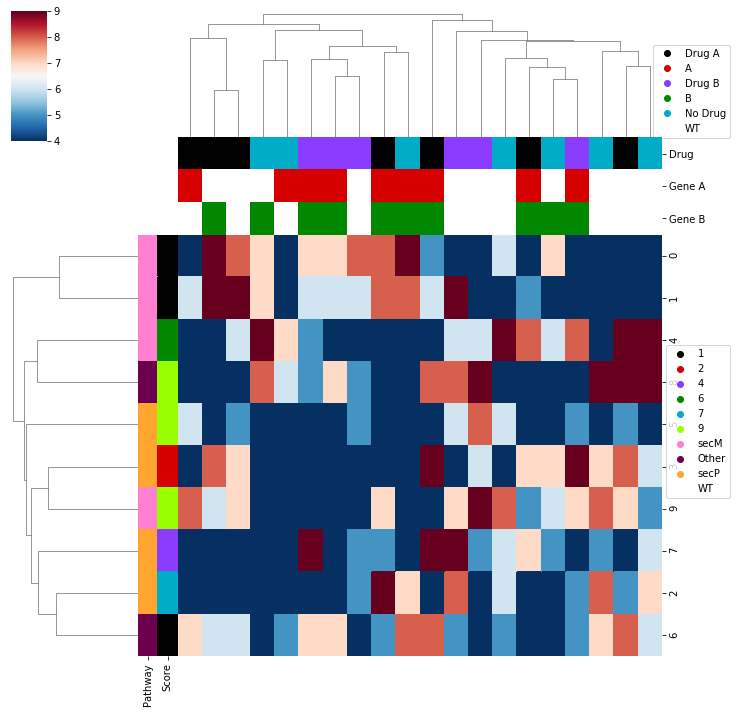

In [26]:
plot_cluster(df,
             row_meta=genes_df,
             col_meta=meta_df,
             fsave=None,
             to_z=False,
             to_col_clust=True,
             to_row_clust=True,
             name=None,
             col_names=False,
             row_names = True,
             to_legend=True,
             method="average" , **{"colors_ratio":(0.03, 0.05), "vmin":4})